# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [4]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isna().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop(columns='Unnamed: 0', inplace=True)

In [9]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData = cigData.rename(columns={'Time':'Month'})

Call a head() to check this has worked. 

In [11]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [12]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [13]:
cigData.Month = pd.to_datetime(cigData.Month)

In [14]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [15]:
cigData.set_index('Month', inplace=True)

In [16]:
cigData.index.freq='MS'

In [17]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed <strike>#Passenger</strike> #CigSales column. 

In [18]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [19]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [20]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

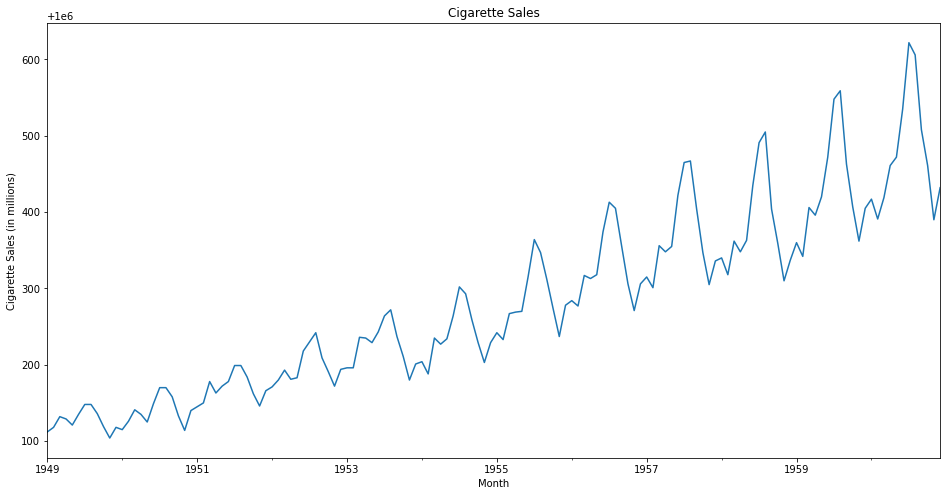

In [21]:
_ = y.plot(figsize=(16,8))
plt.ylabel('Cigarette Sales (in millions)')
_ = plt.title('Cigarette Sales')

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

  * There are consistent peaks and valleys during every year.
  * These appear to be seasonal fluctuations: sales are lowest towards the end of each year, before rising steadily to peak 1, then dipping slightly during the middle of the year, before rising again to a higher peak 2 and then falling off after.
  * In later years, the second and highest peak is much higher than the first. In fact, the range between the low and high of the cigarette sales increases every year.
  * The valleys and peaks increase every year from 1949 to 1960

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

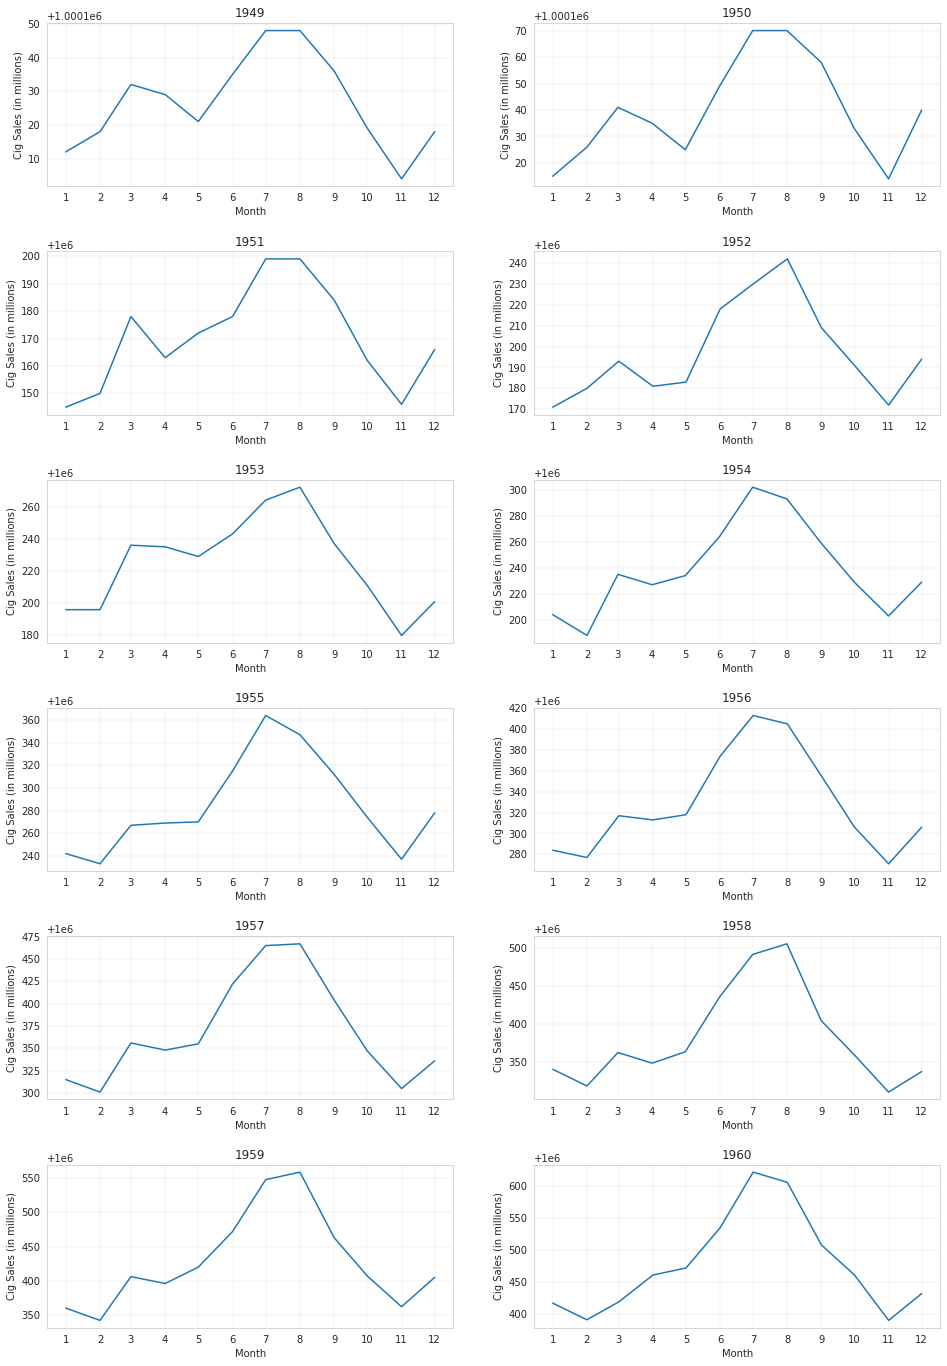

In [22]:
# plot every year in its own subplot
month_list = [i for i in range(1,13)]
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(6, 2, figsize=(16,24), squeeze=False)
    fig.subplots_adjust(wspace=0.2, hspace=0.4)
    for i, year in enumerate(range(1949,1961)):
        ax = axes.flatten()[i]
        yt = y['{0}'.format(year)]
        g = sns.lineplot(yt.index, yt.values, ax=ax)
        ax.set(xlabel='Month', ylabel='Cig Sales (in millions)')
        ax.set_xticks(yt.index)#, minor=True)
        ax.set_xticklabels(month_list)#, minor=True)
        ax.grid(b=True, which='both', color='gray', linewidth=0.1)
        ax.title.set_text(year)

__We tend to see low sales in November, January, and February, with slight uptick in December. We see a slight increase in sales during March, April, and May, and then peak sales occur around July and August. Some possible reasons for these seasonal trends:__

  * Smoking tends to occur outdoors, and since winter months are colder, fewer cigarettes are purchased.
  * The slight uptick in December may be from the stress of the holidays.
  * Longer days in the summer may mean more time for smoking.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

__We appear to have a *multiplicative* model, since the amplitude of the seasonality increases over time.__

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

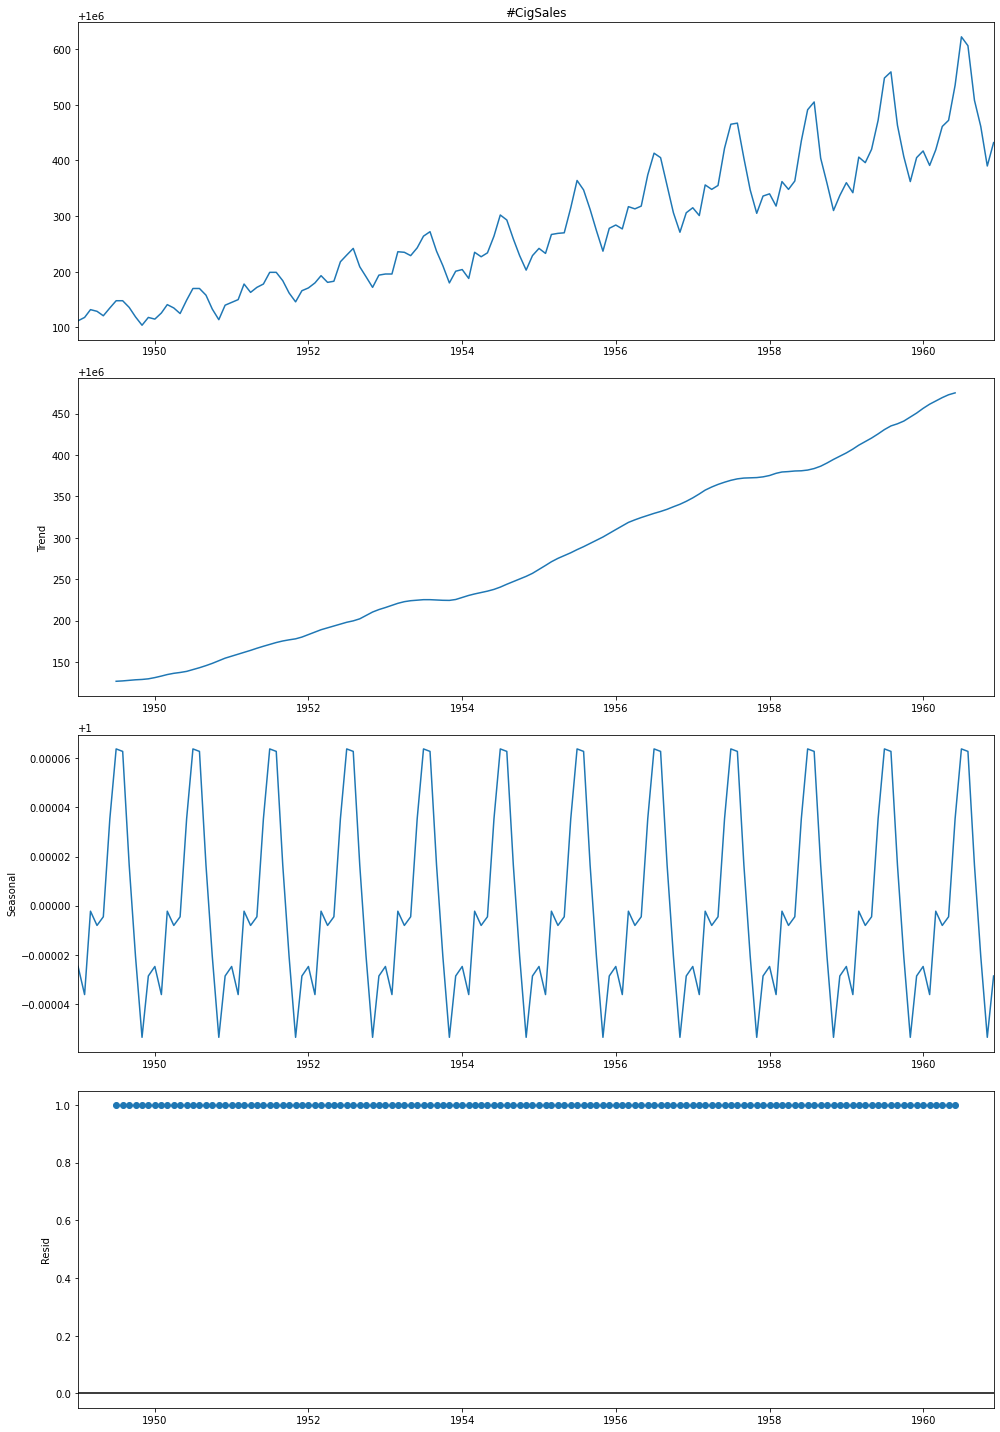

In [23]:
import statsmodels.api as sm
import matplotlib as mpl

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')


with mpl.rc_context():
    mpl.rc("figure", figsize=(14,20))
    decomposition.plot()

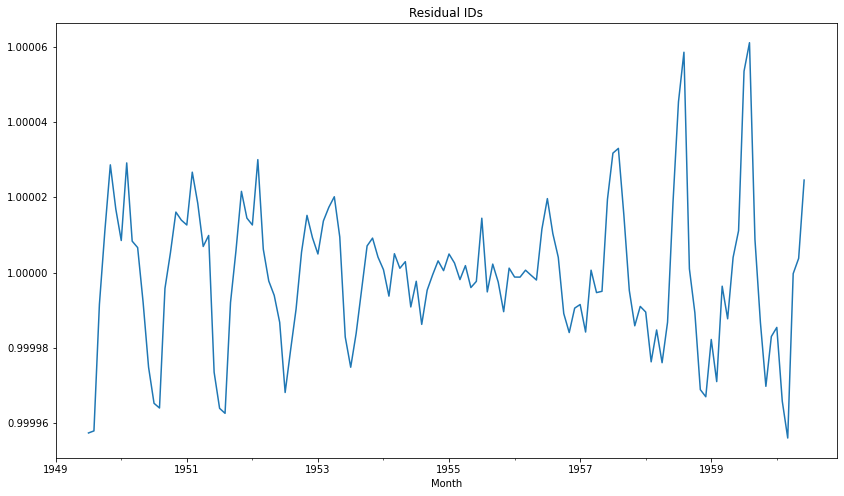

In [24]:
# take a better look at the residual plot
ax = decomposition.resid.plot(title='Residual IDs', figsize=(14,8))
ax.ticklabel_format(axis='y', useOffset=False)

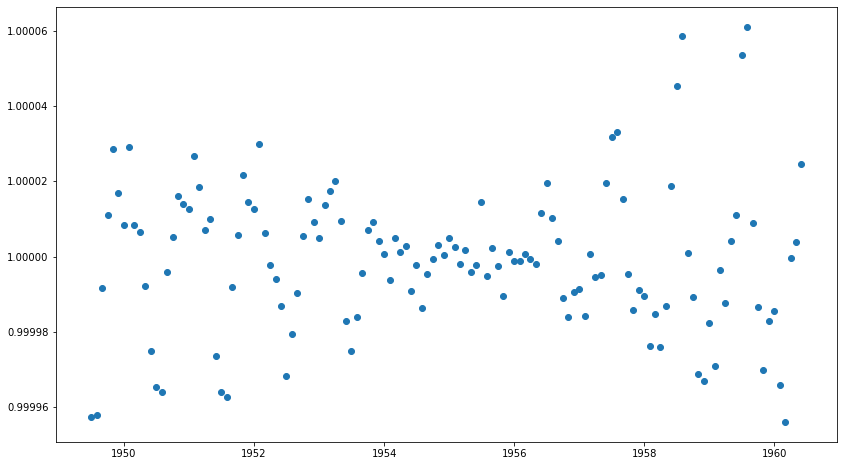

In [25]:
# as a scatter plot
plt.figure(figsize=(14,8))
_ = plt.scatter(decomposition.resid.index, decomposition.resid)
plt.ticklabel_format(axis='y', useOffset=False)

__NOTE: the residuals appear to have a pattern. They shouldn't. See later, when we scale the data.__

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [26]:
from statsmodels.tsa.stattools import kpss

kpss_results = kpss(y, nlags='auto')
kpss_output = ['Test Statistic','p-value','Lags Used']
for i, x in enumerate(kpss_output):
    print('{0: <21} : {1}'.format(x, kpss_results[i]) )
for k,v in kpss_results[3].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : 1.651312235417082
p-value               : 0.01
Lags Used             : 8
Critical Value (10% ) : 0.347
Critical Value (5%  ) : 0.463
Critical Value (2.5%) : 0.574
Critical Value (1%  ) : 0.739


C:\Users\fonta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### Using the augmented Dicky-Fuller test

This tests for trend non-stationarity. The null hypothesis is that the time series is non-stationary.

In [27]:
from statsmodels.tsa.stattools import adfuller

adf_results = adfuller(y)
adf_output = ['Test Statistic','p-value','Lags Used','# of Observations']
for i, x in enumerate(adf_output):
    print('{0: <21} : {1}'.format(x, adf_results[i]) )
for k,v in adf_results[4].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : 0.8153688792057041
p-value               : 0.9918802434376356
Lags Used             : 13
# of Observations     : 130
Critical Value (1%  ) : -3.4816817173418295
Critical Value (5%  ) : -2.8840418343195267
Critical Value (10% ) : -2.578770059171598


The test statistic is highly positive. If it were more negative, it would be more likely to be stationary.

The p-value is very large. We cannot reject the null hypothesis. Thus, the null hypothesis (that the time series is non-stationary) continues to hold.

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

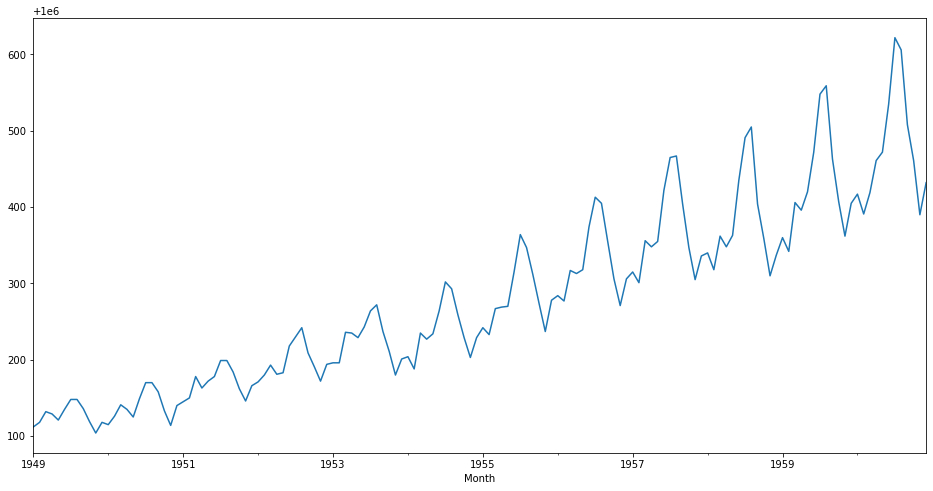

In [28]:
_ = y.plot(figsize=(16,8))

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [29]:
y_log = np.log(y).dropna()


When you plot this, you can see how the variance in our data now remains constant over time.

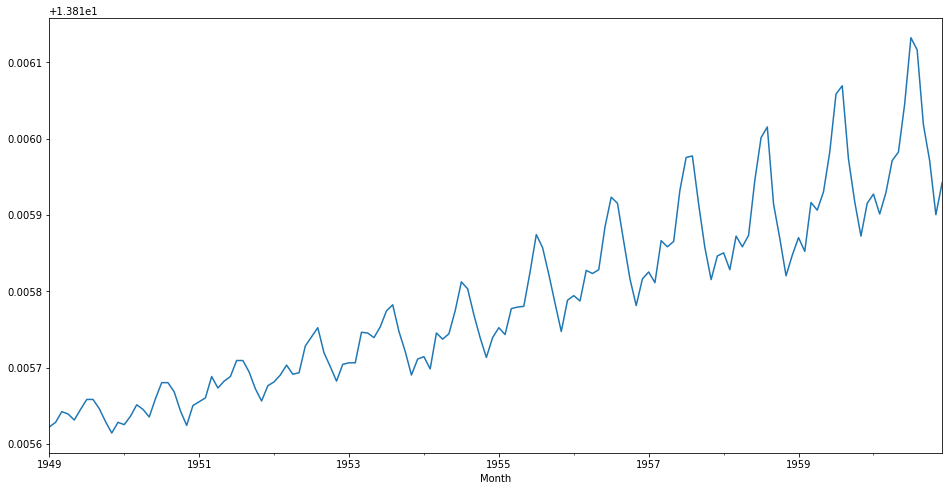

In [30]:
_ = y_log.plot(figsize=(16,8))

__NO! This is not the case! The variance in our data continues to grow over time! Let's verify.__

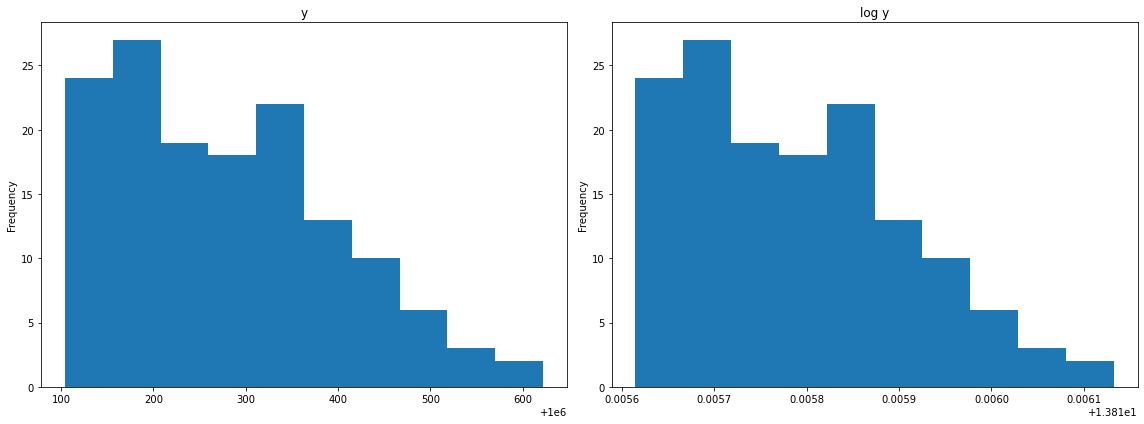

In [31]:
f, axs = plt.subplots(1,2,figsize=(16,6))
_ = y.plot(kind='hist', ax=axs[0], title='y')
_ = y_log.plot(kind='hist', ax=axs[1], title='log y')
plt.tight_layout()

__By plotting the histograms, of the original `y` and also `log y`, we can see that both distributions remain skewed to the right.__

__On the Slack community board, someone figured out that scaling the data would get this notebook back on track. Let's do so.__

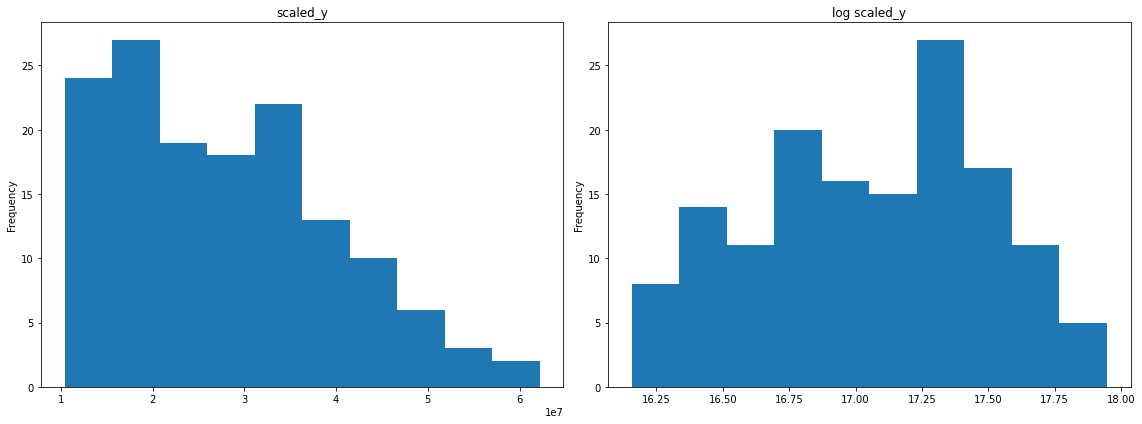

In [32]:
# Scale the data by subtracting 1,000,000 and then multiplying 100,000
scaled_y = (y-1000000)*100000
scaled_y_log = np.log(scaled_y).dropna()

# plot the histograms to verify
f, axs = plt.subplots(1,2,figsize=(16,6))
_ = scaled_y.plot(kind='hist', ax=axs[0], title='scaled_y')
_ = scaled_y_log.plot(kind='hist', ax=axs[1], title='log scaled_y')
plt.tight_layout()

__Let's also take a step back and review the seasonal decomposition with our `scaled_y`.__

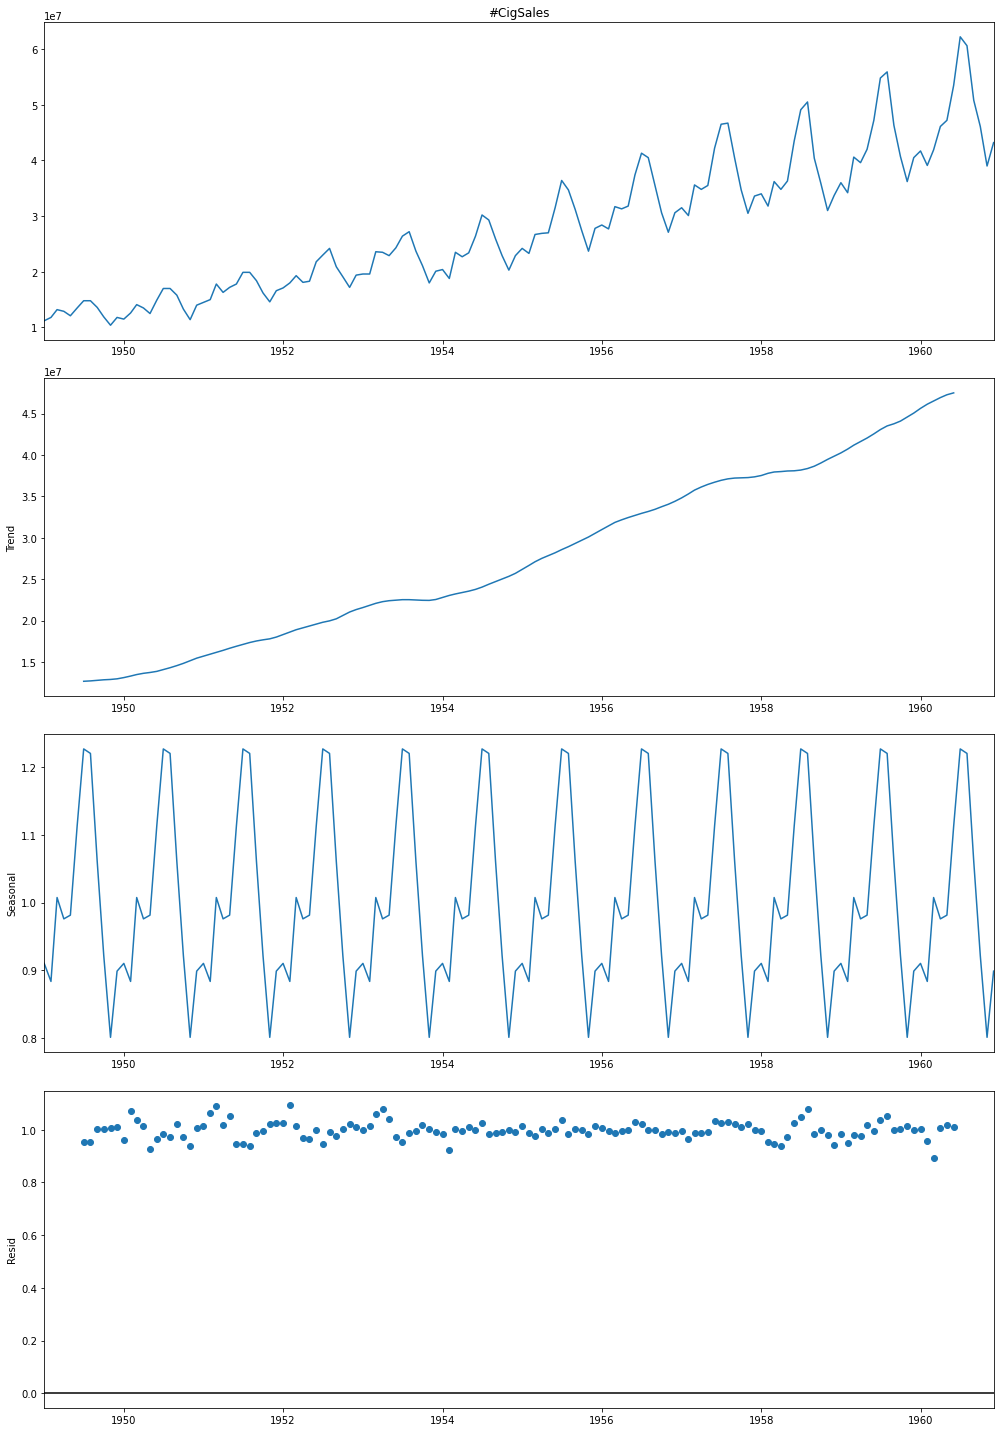

In [33]:
# Now that we've scaled the data, 
# Plot the scaled data, the trend, the seasonality, and the residuals 
decomposition_scaled = sm.tsa.seasonal_decompose(scaled_y, model='multiplicative')

with mpl.rc_context():
    mpl.rc("figure", figsize=(14,20))
    decomposition_scaled.plot()

__Much better! Let's continue with using `scaled_y`.__

__Now when we plot `log scaled_y`, we can see that the variance does indeed remain constant over time.__

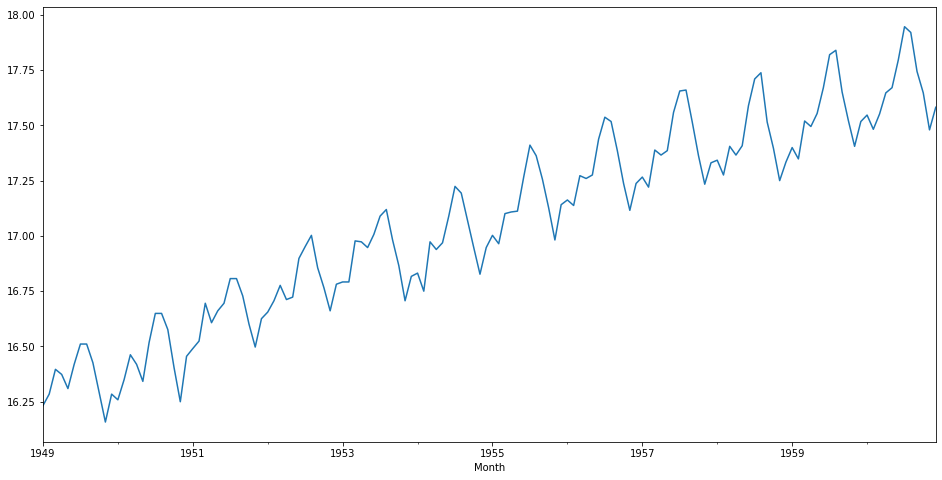

In [34]:
_ = scaled_y_log.plot(figsize=(16,8))

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [35]:
scaled_y_log_diff = scaled_y_log.diff()
scaled_y_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Freq: MS, Name: #CigSales, dtype: float64

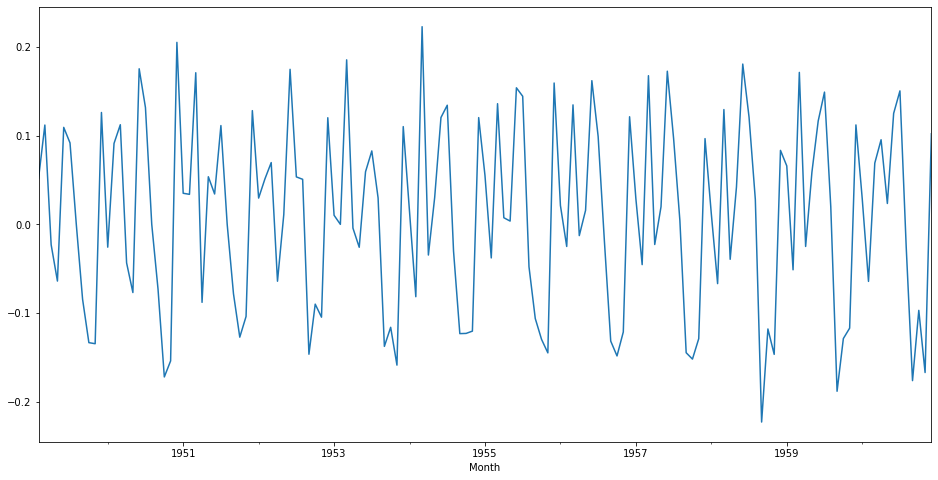

In [36]:
scaled_y_log_diff.dropna(inplace=True)
_ = scaled_y_log_diff.plot(figsize=(16,8))

In [37]:
kpss_results = kpss(scaled_y_log_diff, nlags='auto')
kpss_output = ['Test Statistic','p-value','Lags Used']
for i, x in enumerate(kpss_output):
    print('{0: <21} : {1}'.format(x, kpss_results[i]) )
for k,v in kpss_results[3].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : 0.03830446954674065
p-value               : 0.1
Lags Used             : 6
Critical Value (10% ) : 0.347
Critical Value (5%  ) : 0.463
Critical Value (2.5%) : 0.574
Critical Value (1%  ) : 0.739


C:\Users\fonta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [38]:
# double-check with ADF
adf_results = adfuller(scaled_y_log_diff)
adf_output = ['Test Statistic','p-value','Lags Used','# of Observations']
for i, x in enumerate(adf_output):
    print('{0: <21} : {1}'.format(x, adf_results[i]) )
for k,v in adf_results[4].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : -2.7171305983881364
p-value               : 0.07112054815085811
Lags Used             : 14
# of Observations     : 128
Critical Value (1%  ) : -3.4825006939887997
Critical Value (5%  ) : -2.884397984161377
Critical Value (10% ) : -2.578960197753906


The test statistic is now negative! Much more likely to be stationary.

The p-value is much smaller, although it is not below 0.05. We'll continue on with the notebook anyway.

### Examine ACF and PACF

Now that we know how to make our data stationary, we can use ACF and PACF plots to help us determine which ARIMA models to fit.

We first plot the ACF and PACF for our scaled data to determine ARMA(p,q), we already know that d = 1 as we determine first order differencing of our transformed data made it stationary.

In [39]:
# imports
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

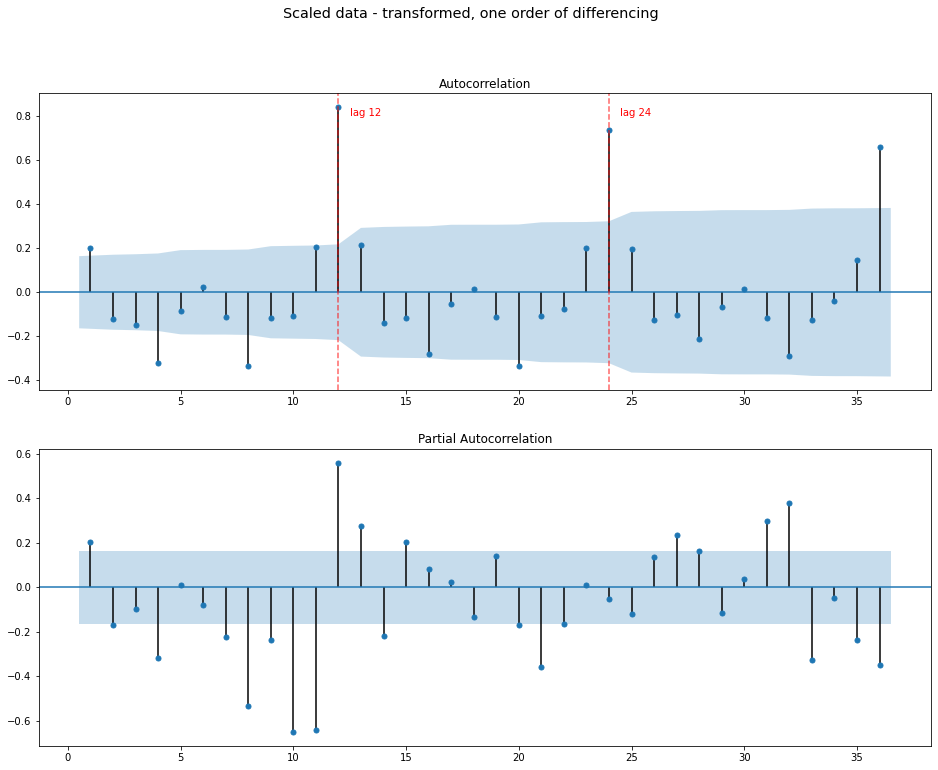

In [40]:
# scaled data
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,12))
# ACF
plot_acf(scaled_y_log_diff, lags=36, zero=False, ax=ax1)
# add seasonality lines
ax1.axvline(12, color='red', ls='--', alpha=0.6)
ax1.axvline(24, color='red', ls='--', alpha=0.6)
ax1.annotate('lag 12', (12.5, 0.8), color='red')
ax1.annotate('lag 24', (24.5, 0.8), color='red')
# PACF
plot_pacf(scaled_y_log_diff, lags=36, zero=False, ax=ax2)
plt.suptitle('Scaled data - transformed, one order of differencing', fontsize='x-large')
plt.show()

__We can see the seasonality in the ACF, a seasonal period of 12, which suggests a seasonal difference must be applied. We can also see a trend.__

__It's hard to tell the orders of p or q from the ACF and PACF plots.__

Next, we look for the seasonal component's (P, D, Q). We know S = 12. We must take our transformed data, perform our first order of differencing, then apply a seasonal differencing and plot the ACF and PACF accordingly.

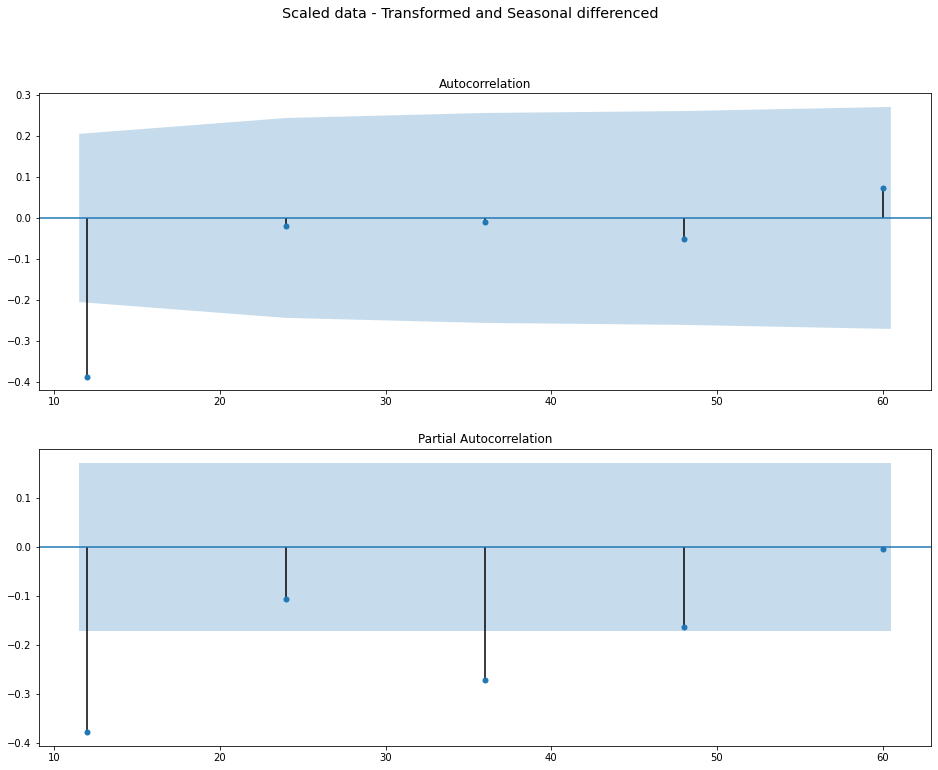

In [41]:
seasonal_diff = scaled_y_log.diff().diff(12).dropna()

# plot seasonal_diff data
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,12))
# ACF
plot_acf(seasonal_diff, lags=[12,24,36,48,60], zero=False, ax=ax1)
# PACF
plot_pacf(seasonal_diff, lags=[12,24,36,48,60], zero=False, ax=ax2)
plt.suptitle('Scaled data - Transformed and Seasonal differenced', fontsize='x-large')
plt.show()

__It appears that the Seasonal ACF cuts off after the 1st seasonal lag, while the Season PACF tails off. so we should have a SARMA(0,1) model for our seasonal component. Remember, our seasonal differencing D = 1.__

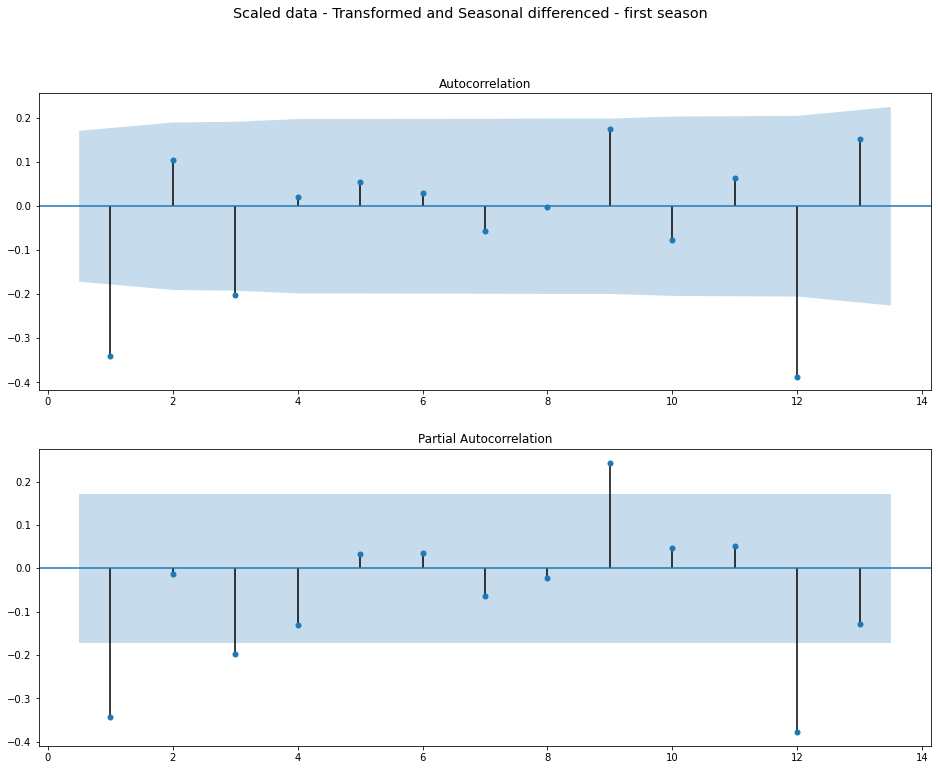

In [42]:
# plot seasonal_diff data
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,12))
# ACF
plot_acf(seasonal_diff, lags=13, zero=False, ax=ax1)
# PACF
plot_pacf(seasonal_diff, lags=13, zero=False, ax=ax2)
plt.suptitle('Scaled data - Transformed and Seasonal differenced - first season', fontsize='x-large')
plt.show()

__Within the first seasonal cycle, the ACF tails off while the PACF cuts off after lag 2. Thus, we might propose an AR(2) model for the non-seasonal component. All in all, this would suggest a SARIMA(2,1,0)x(0,1,1)12 model.__

### 3d. The <s>ARIMA</s> SARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

__Note: We already see that seasonality exists in the data. Thus, we will use `SARIMAX` instead of `ARIMA`.__

In [43]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 3di. Make a function to find the MSE of a single <s>ARIMA</s> SARIMA model

In [44]:
# Make a function called evaluate_arima_model to find the MSE and AIC of a single ARIMA model 
def get_SARIMAX_mse_aic(data, order, seasonal_order):
    # use the last 24 months as test
    train = data.iloc[:len(data)-24]
    test = data.drop(train.index)
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast(steps=len(test))
    # note that we can also use model_fit.predict() 
    # pred = model_fit.predict(start=len(train), end=len(data))
    
    # Return the error
    return mean_squared_error(test, pred), model_fit.aic

In [45]:
# test the function
print('MSE, AIC: ', get_SARIMAX_mse_aic(scaled_y_log, (2,1,0), (0,1,1,12)))

MSE, AIC:  (0.0101717975424726, -386.65673698908614)


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [46]:
# evaluate different SARIMA models with several different p, q, and seasonal P, Q values. 
# to reduce loops, pass in the d and seasonal D values, as well as the seasonal s value
def evaluate_seasonal_models(dataset, d, p_values, q_values, seasonal_D, seasonal_P_values, seasonal_Q_values, seasonal_s):
    best_mse_score, best_mse_order, best_mse_seasonal_order, best_mse_aic = float("inf"), None, None, float("inf")
    best_aic_score, best_aic_order, best_aic_seasonal_order, best_aic_mse = float("inf"), None, None, float("inf")
    # Iterate through p_values
    for p in p_values:
        # Iterate through q_values
        for q in q_values:
            # Iterate through seasonal_P_values
            for P in seasonal_P_values:
                # Iterate through seasonal_Q_values
                for Q in seasonal_Q_values:
                    order = (p, d, q)
                    seasonal_order = (P, seasonal_D, Q, seasonal_s)
                    try:
                        # Make a variable called mse for the Mean squared error
                        mse, aic = get_SARIMAX_mse_aic(dataset, order, seasonal_order)
                        if mse < best_mse_score:
                            best_mse_score, best_mse_order, best_mse_seasonal_order, best_mse_aic = mse, order, seasonal_order, aic
                        if aic < best_aic_score:
                            best_aic_score, best_aic_order, best_aic_seasonal_order, best_aic_mse = aic, order, seasonal_order, mse
                        print('SARIMA%sx%s MSE=%.5f AIC=%.3f' % (order,seasonal_order,mse,aic))
                    except:
                        continue
    print('\n(Using MSE) Best SARIMA%sx%s MSE=%.5f AIC=%.5f' % (best_mse_order, best_mse_seasonal_order, best_mse_score, best_mse_aic))
    print('\n(Using AIC) Best SARIMA%sx%s MSE=%.5f AIC=%.5f' % (best_aic_order, best_aic_seasonal_order, best_aic_mse, best_aic_score))
    return 

In [47]:
# Now, we choose a couple of values to try for each parameter:
p_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]
seasonal_P_values = [x for x in range(0, 2)]
seasonal_Q_values = [x for x in range(0, 2)]

In [48]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")

# we are setting the order of differencing to 1 for both non-seasonal d and seasonal D
print('Running with d=1 and D=1')
evaluate_seasonal_models(scaled_y_log, 1, p_values, q_values, 1, seasonal_P_values, seasonal_Q_values, 12)

Running with d=1 and D=1
SARIMA(0, 1, 0)x(0, 1, 0, 12) MSE=0.03151 AIC=-353.412
SARIMA(0, 1, 0)x(0, 1, 1, 12) MSE=0.01109 AIC=-379.989
SARIMA(0, 1, 0)x(1, 1, 0, 12) MSE=0.01849 AIC=-371.546
SARIMA(0, 1, 0)x(1, 1, 1, 12) MSE=0.01112 AIC=-377.994
SARIMA(0, 1, 1)x(0, 1, 0, 12) MSE=0.02784 AIC=-364.326
SARIMA(0, 1, 1)x(0, 1, 1, 12) MSE=0.00920 AIC=-389.010
SARIMA(0, 1, 1)x(1, 1, 0, 12) MSE=0.01400 AIC=-384.232
SARIMA(0, 1, 1)x(1, 1, 1, 12) MSE=0.00904 AIC=-387.220
SARIMA(0, 1, 2)x(0, 1, 0, 12) MSE=0.02740 AIC=-362.421
SARIMA(0, 1, 2)x(0, 1, 1, 12) MSE=0.00889 AIC=-387.065
SARIMA(0, 1, 2)x(1, 1, 0, 12) MSE=0.01386 AIC=-382.250
SARIMA(0, 1, 2)x(1, 1, 1, 12) MSE=0.00874 AIC=-385.272
SARIMA(1, 1, 0)x(0, 1, 0, 12) MSE=0.02972 AIC=-363.573
SARIMA(1, 1, 0)x(0, 1, 1, 12) MSE=0.01026 AIC=-388.643
SARIMA(1, 1, 0)x(1, 1, 0, 12) MSE=0.01593 AIC=-383.358
SARIMA(1, 1, 0)x(1, 1, 1, 12) MSE=0.01017 AIC=-386.775
SARIMA(1, 1, 1)x(0, 1, 0, 12) MSE=0.02681 AIC=-362.564
SARIMA(1, 1, 1)x(0, 1, 1, 12) MSE=0.0077

<s>So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. </s>

__Looks like the best model using MSE is a SARIMA(2, 1, 1)x(0, 1, 0, 12)! It has a MSE of 0.00517 and an AIC of -363.214.__

__Note, however, that if using AIC, the best model would be SARIMA(0, 1, 1)x(0, 1, 1, 12). It has a MSE of 0.00920 and an AIC of -389.00975.__

__Aside: our ACF/PACF projected model of SARIMA(2,1,0)x(0,1,1,12) came in with fair results, but not as low an MSE or AIC. (a MSE of 0.01017 and an AIC of -386.657.)__

Let's also look at the results for some different orders of differencing.

In [49]:
print('Running with d=1 and D=0')
evaluate_seasonal_models(scaled_y_log, 1, p_values, q_values, 0, seasonal_P_values, seasonal_Q_values, 12)

Running with d=1 and D=0
SARIMA(0, 1, 0)x(0, 0, 0, 12) MSE=0.10437 AIC=-194.869
SARIMA(0, 1, 0)x(0, 0, 1, 12) MSE=0.10584 AIC=-274.945
SARIMA(0, 1, 0)x(1, 0, 0, 12) MSE=0.03772 AIC=-376.581
SARIMA(0, 1, 0)x(1, 0, 1, 12) MSE=0.00740 AIC=-392.183
SARIMA(0, 1, 1)x(0, 0, 0, 12) MSE=0.08786 AIC=-198.889
SARIMA(0, 1, 1)x(0, 0, 1, 12) MSE=0.10125 AIC=-274.209
SARIMA(0, 1, 1)x(1, 0, 0, 12) MSE=0.03349 AIC=-383.416
SARIMA(0, 1, 1)x(1, 0, 1, 12) MSE=0.01078 AIC=-405.422
SARIMA(0, 1, 2)x(0, 0, 0, 12) MSE=0.07940 AIC=-201.162
SARIMA(0, 1, 2)x(0, 0, 1, 12) MSE=0.09941 AIC=-272.671
SARIMA(0, 1, 2)x(1, 0, 0, 12) MSE=0.03221 AIC=-381.681
SARIMA(0, 1, 2)x(1, 0, 1, 12) MSE=0.01014 AIC=-403.581
SARIMA(1, 1, 0)x(0, 0, 0, 12) MSE=0.09385 AIC=-197.184
SARIMA(1, 1, 0)x(0, 0, 1, 12) MSE=0.10205 AIC=-274.048
SARIMA(1, 1, 0)x(1, 0, 0, 12) MSE=0.03534 AIC=-382.995
SARIMA(1, 1, 0)x(1, 0, 1, 12) MSE=0.01166 AIC=-405.147
SARIMA(1, 1, 1)x(0, 0, 0, 12) MSE=0.08371 AIC=-201.680
SARIMA(1, 1, 1)x(0, 0, 1, 12) MSE=0.1009

__Wow! With no seasonal orders of differencing, the best model using MSE is a SARIMA(2, 1, 1)x(1, 0, 1, 12) with a MSE of 0.00097 and an even lower AIC of -397.98298! This is even lower than our earlier SARIMA(2, 1, 1)x(0, 1, 0, 12) with a MSE of 0.00517 and an AIC of -363.214.__

__Note, again, however, that if we were using AIC to determine best model, we would choose SARIMA(0, 1, 1)x(1, 0, 1, 12) MSE=0.01078 AIC=-405.42208. Compared to earlier ( when the lowest AIC was SARIMA(0, 1, 1)x(0, 1, 1, 12) MSE=0.00920 AIC=-389.00975 ) we have a slightly higher MSE but lower AIC.__

Now we know this, we can build the model.

__We will go with the SARIMA(2, 1, 1)x(1, 0, 1, 12) for now.__

In [50]:
# building this model on the full dataset
model = SARIMAX(scaled_y_log, order=(2,1,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()

We can take a look at a summary of the model this library has built around our data.

In [51]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 255.931
Date:                            Wed, 28 Apr 2021   AIC                           -499.862
Time:                                    11:59:39   BIC                           -482.084
Sample:                                01-01-1949   HQIC                          -492.638
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5825      0.105      5.547      0.000       0.377       0.788
ar.L2          0.1987      0.087      2.289      0.022       0.029       0.369
ma.L1         -0.9443      0.063    -14.916      0.000      -1.068      -0.820
ar.S.L12       0.9901      0.008    126.112      0.000       0.975       1.005
ma.S.L12      -0.5616      0.110     -5.124      0.000      -0.776      -0.347
sigma2         0.0013      0.000      8.582      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       39.69   Jarque-Bera (JB):                 5.21
Prob(Q):                              0.48   Prob(JB):                         0.07
Heteroskedasticity (H):               0.64   Skew:                             0.05
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
print('MSE: %.5f AIC: %.5f' % (model_fit.mse, model_fit.aic))

MSE: 1.83156 AIC: -499.86156


In [53]:
pred = model_fit.predict()[12:]

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

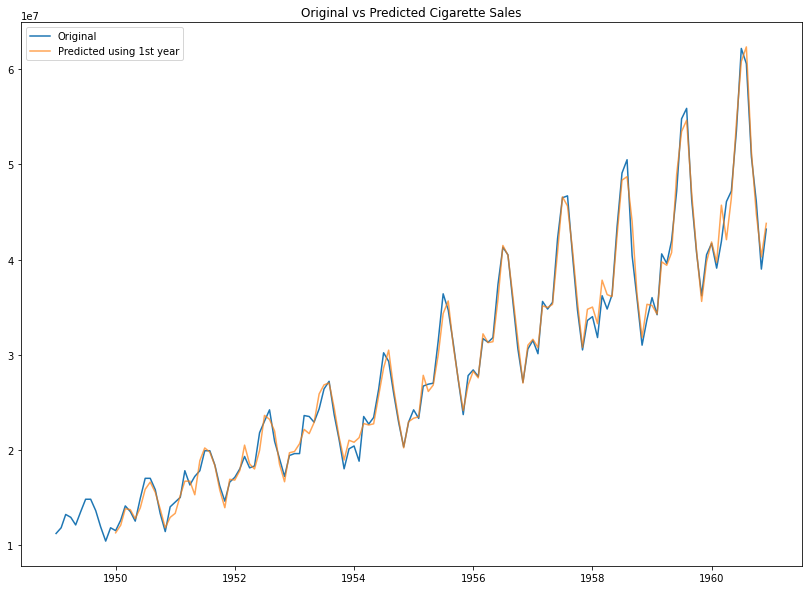

In [54]:
plt.figure(figsize=(14,10))

plt.title('Original vs Predicted Cigarette Sales')
plt.plot(np.exp(scaled_y_log), label='Original')
plt.plot(np.exp(pred), label='Predicted using 1st year', alpha=0.7)

_ = plt.legend()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [55]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
forecast_date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_data = pd.DataFrame(forecast_date_range, columns=['Month'])
future_data.Month = pd.to_datetime(future_data.Month)
future_data.set_index('Month', inplace = True)
future_data['Prediction'] = model_fit.forecast(forecast_period)

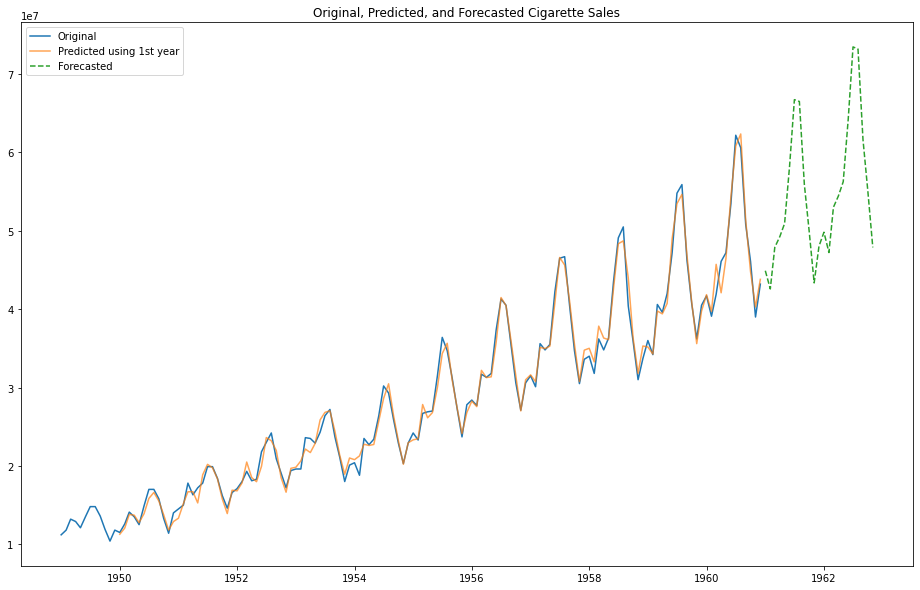

In [56]:
# Plot your future predictions
plt.figure(figsize=(16,10))

plt.title('Original, Predicted, and Forecasted Cigarette Sales')
plt.plot(np.exp(scaled_y_log), label='Original')
plt.plot(np.exp(pred), label='Predicted using 1st year', alpha=0.7)
plt.plot(np.exp(future_data), label='Forecasted', ls='--')

_ = plt.legend()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

## 5. Further evaluation: Using pmdarima

We will use the `pmdarima` library's `auto_arima` to determine our optimal parameters. `auto_arima` utilizes AIC (Akaike Information Critera) to choose best model. Furthermore, since our data is seasonal, our best model may in fact be SARIMA, instead of ARIMA.

In [57]:
# imports
import pmdarima as pm

In [58]:
stepwise_fit = pm.auto_arima(scaled_y_log, 
                   start_p=0, start_q=0, max_p=3, max_q=3, 
                   m=12,
                   d=1, max_D=1,
                   start_P=0, start_Q=0, max_P=2, max_Q=2,
                   error_action='ignore', 
                   trace=True,
                   suppress_warnings=True, # don't want convergence warnings
                   maxiter=40,
                   seasonal=True, 
                   stepwise=True )

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.47 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.955, Time=1.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=1.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.29 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=0.96 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-481.400, Time=0.46 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Wed, 28 Apr 2021   AIC                           -483.393
Time:                                    11:59:49   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4021      0.073     -5.506      0.000      -0.545      -0.259
ma.S.L12      -0.5572      0.096     -5.786      0.000      -0.746      -0.368
sigma2         0.0013      0.000      9.120      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.37   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.59   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5a. Building the model

So the best model is __SARIMAX(0, 1, 1)x(0, 1, 1, 12)__ . Note that the seasonal differencing order = 1 here. This was determined in `pmdarima` by performing an OCSB test of seasonality. Now we know this, we can build the model.

In [59]:
# fit the model
model2 = SARIMAX(scaled_y_log, order=(0,1,1), seasonal_order=(0,1,1,12))
model2_fit = model2.fit()

We can take a look at a summary of the model this library has built around our data.

In [60]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Wed, 28 Apr 2021   AIC                           -483.393
Time:                                    11:59:50   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4021      0.073     -5.506      0.000      -0.545      -0.259
ma.S.L12      -0.5572      0.096     -5.786      0.000      -0.746      -0.368
sigma2         0.0013      0.000      9.120      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.37   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.59   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
print('MSE: %.5f AIC: %.5f' % (model2_fit.mse, model2_fit.aic))

MSE: 2.29185 AIC: -483.39296


In [66]:
pred2 = model2_fit.predict()[24:]

### 5b. Visualize the results 

Visualize the original dataset plotted against our model. 

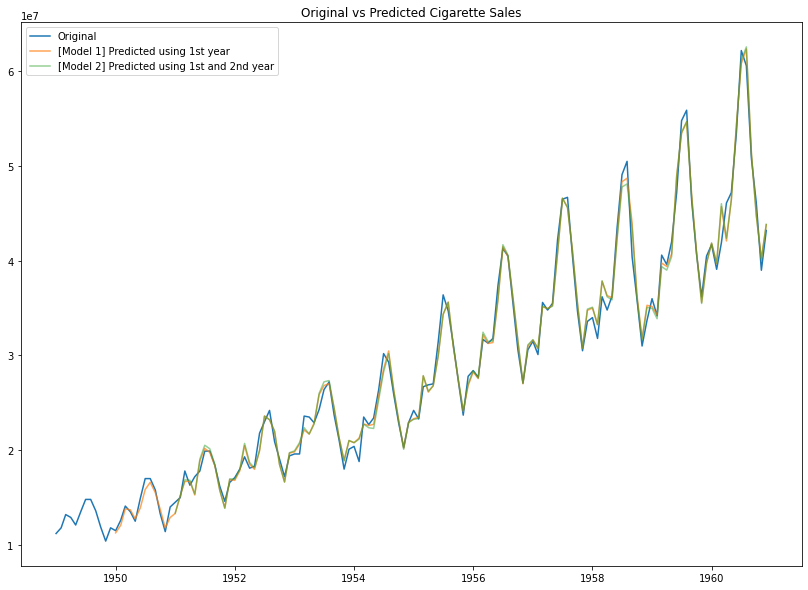

In [67]:
plt.figure(figsize=(14,10))

plt.title('Original vs Predicted Cigarette Sales')
plt.plot(np.exp(scaled_y_log), label='Original')
plt.plot(np.exp(pred), label='[Model 1] Predicted using 1st year', alpha=0.7)
plt.plot(np.exp(pred2), label='[Model 2] Predicted using 1st and 2nd year', alpha=0.5)

_ = plt.legend()

### 5c. Application: Forecasting

Both the `pmdarima`'s model and our MSE-derived model from earlier look very similar. Let's look at the forecasts.

In [72]:
# Convert that range into a dataframe that includes your predictions
future_data2 = pd.DataFrame(forecast_date_range, columns=['Month'])
future_data2.Month = pd.to_datetime(future_data2.Month)
future_data2.set_index('Month', inplace = True)
future_data2['Prediction'] = model2_fit.forecast(forecast_period)

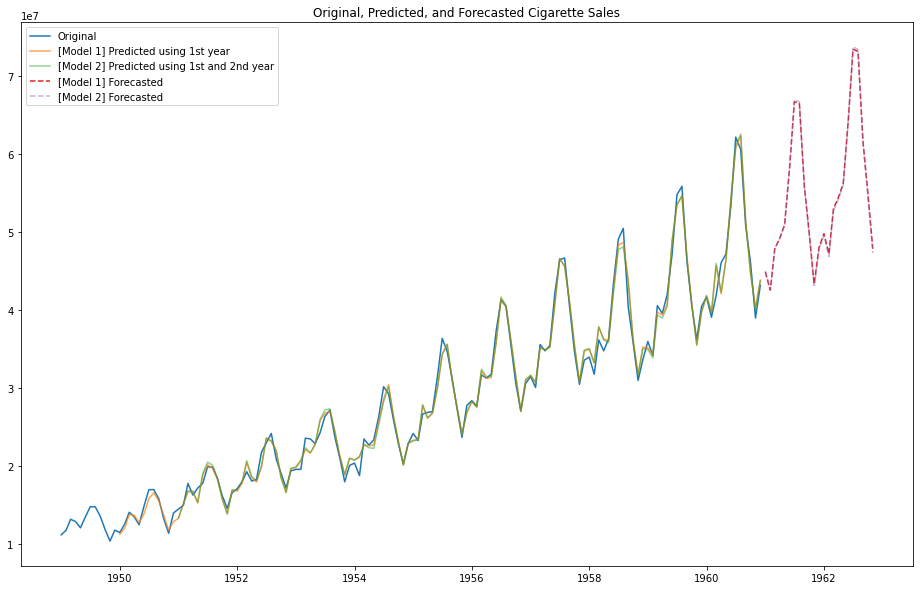

In [75]:
plt.figure(figsize=(16,10))

plt.title('Original, Predicted, and Forecasted Cigarette Sales')
plt.plot(np.exp(scaled_y_log), label='Original')
plt.plot(np.exp(pred), label='[Model 1] Predicted using 1st year', alpha=0.7)
plt.plot(np.exp(pred2), label='[Model 2] Predicted using 1st and 2nd year', alpha=0.5)
plt.plot(np.exp(future_data), label='[Model 1] Forecasted', ls='--')
plt.plot(np.exp(future_data2), label='[Model 2] Forecasted', ls='--', alpha=0.5)

_ = plt.legend()

In [84]:
future_data.join(future_data2, lsuffix='_1', rsuffix='_2')

,Prediction_1,Prediction_2
Month,,
1960-12-01,NaN,NaN
1961-01-01,17.620089,17.623116
1961-02-01,17.566996,17.566712
1961-03-01,17.684496,17.684669
1961-04-01,17.712380,17.712229
1961-05-01,17.746046,17.745482
1961-06-01,17.880328,17.881711
1961-07-01,18.016335,18.020216
1961-08-01,18.012818,18.015833


### 5d. Evaluating and Concluding

Both the models are really incredibly close! 